In [314]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import math as m
import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

import ROOT as rt

import root_numpy as rnp

from aputils.latextables.tables import Table
import itertools as itools
from collections import namedtuple

# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)
udeg2rad = unc.wrap(np.deg2rad)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
#axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [783]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

def axis_scale(axis="x",scale=1):
    if axis == "x":
        axis = plt.gca().xaxis
    elif axis == "y":
        axis = plt.gca().yaxis
    axis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,_ : float(x)*scale))  
    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)


In [1286]:
#Laden der Messwerte 
#element_right = pd.read_csv(path_data+"Distanzen_Probe_rechts.csv",comment="#")
#element_left  = pd.read_csv(path_data+"Distanzen_Probe_links.csv",comment="#")
#salt_right = pd.read_csv(path_data+"Distanzen_Salz_rechts.csv",comment="#")
#salt_left  = pd.read_csv(path_data+"Distanzen_Salz_links.csv",comment="#")
element_left = pd.read_csv(path_data+"Distanzen_Probe_rechts.csv",comment="#")
element_right  = pd.read_csv(path_data+"Distanzen_Probe_links.csv",comment="#")
salt_right = pd.read_csv(path_data+"Distanzen_Salz_rechts.csv",comment="#")
salt_left  = pd.read_csv(path_data+"Distanzen_Salz_links.csv",comment="#")
error = pd.read_csv(path_data+"Messfehler.csv",comment="#")
constants = pd.read_csv(path_data+"Distanzen.csv",comment="#")
# In 1e-10
wavelengths = pd.read_csv(path_data+"Wellenlaengen.csv",comment="#")
wavelengths["KaDev"] = (wavelengths.Ka1-wavelengths.Ka2)/wavelengths["KaMean"]
wavelengths

,Ka1,Ka2,KaMean,KaDev
0,1.54093,1.54478,1.5417,-0.002497


In [1287]:
# Fehlerbehaftete Messwerte
element_right_err = errors_in_dataframe(element_right,[error.x,error.x])
element_left_err = errors_in_dataframe(element_left,[error.x,error.x])
salt_right_err = errors_in_dataframe(salt_right,[error.x,error.x])
salt_left_err = errors_in_dataframe(salt_left,[error.x,error.x])
constants_err = errors_in_dataframe(constants,[error.x])

In [1238]:
def errors_in_dataframe(dataframe,error):
    df = dataframe.copy()
    for i,column in enumerate(df.columns):
        df[column] = unp.uarray(dataframe[column],error[i])
    return df
 
def calc_diameter(dataframe):
    dataframe["diameter"] = dataframe["x2"] - dataframe["x1"]
def calc_angle_right(dataframe,dist_2_deg = np.pi/constants_err.d.values):
    dataframe["Theta4"] = dataframe["diameter"]*dist_2_deg
    dataframe["Theta"] = dataframe["Theta4"]/4 
    
def calc_angle_left(dataframe,dist_2_deg = np.pi/constants_err.d.values):
    dataframe["Phi4"] = dataframe["diameter"]*dist_2_deg
    dataframe["Theta4"] = 2*np.pi - dataframe["Phi4"]  
    dataframe["Theta"] = dataframe["Theta4"]/4 

def sin_cos2_theta(dataframe):
    dataframe["sinTheta"] = unp.sin(dataframe.Theta)
    dataframe["cosThetaSq"] = unp.cos(dataframe.Theta)**2
    #dataframe["sinThetaSq"] = dataframe["sinTheta"]**2

def angle_deviation(dataframe):
    a = wavelengths.KaDev[0]
    dataframe["dTheta"] = a*unp.tan(dataframe.Theta)

def calc_bragg_d(dataframe):
    l = [wavelengths.KaMean[0]]*len(dataframe)
    dataframe["d_bragg"] = l/(2*dataframe["sinTheta"])

def norm_bragg_d(dataframe):
    Max = max(dataframe["d_bragg"])
    dataframe["d_bragg_norm"] = Max/dataframe["d_bragg"].values

def check_permutation(tup1,tup2):
    return all(np.sort(tup1) == np.sort(tup2))
    
def non_missing_reflexes(basis_atom1=[(0,0,0)],basis_atom2=None,maxidx=5):
    idcs = np.arange(0,maxidx+1)
    HKL = []
    for l in idcs:
        for k in idcs:
            for h in idcs:
                HKL.append((h,k,l))
   
    #K = np.arange(0,k+1)
    #L = np.arange(0,l+1)
    if basis_atom2 == None:
        Amp = lambda (x,y,z),(h,k,l):  np.exp(np.complex(0,-2*np.pi)*(h*x+k*y+l*z))
        all_amps = []
        sums = []
        for hkl in HKL:
            summands = []
            for vec in basis_atom1:
                summands.append(Amp(vec,hkl))
            amp = sum(summands)
            #print(amp," ",hkl)
            if abs(np.real(amp)) > 1e-10:
                sums.append(amp)
                all_amps.append(hkl)
    else:
        Amp = lambda af,(x,y,z),(h,k,l): af* np.exp(np.complex(0,-2*np.pi)*(h*x+k*y+l*z))
        all_amps = []
        sums = []
        for hkl in HKL:
            summands = []
            for vec in basis_atom1:
                summands.append(Amp(1,vec,hkl))
            for vec in basis_atom2:
                summands.append(Amp(10,vec,hkl))    
            amp = sum(summands)
            #print(amp," ",hkl)
            if abs(np.real(amp)) > 1e-10:
                sums.append(amp)
                all_amps.append(hkl)
    return np.array(all_amps[1:]),sums

def clear_permutations(List,amps):
    all_idcs = []
    for tup1 in List:
        idcs = []
        for i,tup2 in enumerate(List,start=0):
            if check_permutation(tup1,tup2):
                idcs.append(i)
        all_idcs.append(idcs)
    all_idcs = np.unique(all_idcs)
    all_permutations = []
    for idc in all_idcs:
        all_permutations.append(List[idc])
    cleared = []
    for permutaion in all_permutations:
        cleared.append(permutaion[0])
    m = []
    for hkl in cleared:
        m.append(np.sqrt(hkl[0]**2 + hkl[1]**2 +hkl[2]**2))
    amps = np.array(amps)
    m = np.array(m)
    cleared = np.array(cleared)
    m_sort = np.argsort(m)
    m = m[m_sort]
    cleared = cleared[m_sort]
    amps = amps[m_sort]
    return cleared,m,amps



def reflexes_and_roothkl(basis_atom1 = [(0,0,0)],basis_atom2=None,maxidx=5):
    reflexes,sums = non_missing_reflexes(basis_atom1= basis_atom1,basis_atom2= basis_atom2,maxidx=maxidx)
    hkl,root,sums = clear_permutations(reflexes,sums)
    df = pd.DataFrame({"hkl":tuple(hkl),"m":root,"amplitude":sums})
    df["idxsum"] = [h+10*k+100*l for (h,k,l) in tuple(hkl)]
    return df.sort_index(by=["m","idxsum"])
def norm_m(dataframe):
    Min = min(dataframe.m.values)
    dataframe["m_norm"] = dataframe.m/Min

In [1005]:
sc = reflexes_and_roothkl(basis_atom1 = [(0,0,0)],maxidx=5)
norm_m(sc)
sc.head(10)

,amplitude,hkl,m,idxsum,m_norm
0,(1+0j),"[1, 0, 0]",1.000000,1,1.000000
1,(1+0j),"[1, 1, 0]",1.414214,11,1.414214
2,(1+0j),"[1, 1, 1]",1.732051,111,1.732051
3,(1+0j),"[2, 0, 0]",2.000000,2,2.000000
4,(1+0j),"[2, 1, 0]",2.236068,12,2.236068
5,(1+0j),"[2, 1, 1]",2.449490,112,2.449490
6,(1+0j),"[2, 2, 0]",2.828427,22,2.828427
8,(1+0j),"[3, 0, 0]",3.000000,3,3.000000
7,(1+0j),"[2, 2, 1]",3.000000,122,3.000000
9,(1+0j),"[3, 1, 0]",3.162278,13,3.162278


In [956]:
bcc = reflexes_and_roothkl(basis_atom1=[(0,0,0),(0.5,0.5,0.5)],maxidx=5)
norm_m(bcc)
bcc.head(10)

,amplitude,hkl,m,idxsum,m_norm
0,(2+4.89858719659e-16j),"[1, 1, 0]",1.414214,11,1.000000
1,(2+0j),"[2, 0, 0]",2.000000,2,1.414214
2,(2+9.79717439318e-16j),"[2, 1, 1]",2.449490,112,1.732051
3,(2+7.34788079488e-16j),"[2, 2, 0]",2.828427,22,2.000000
4,(2+2.44929359829e-16j),"[3, 1, 0]",3.162278,13,2.236068
5,(2+1.22464679915e-15j),"[2, 2, 2]",3.464102,222,2.449490
6,(2+7.34788079488e-16j),"[3, 2, 1]",3.741657,123,2.645751
7,(2+2.44929359829e-16j),"[4, 0, 0]",4.000000,4,2.828427
8,(2+4.89858719659e-16j),"[3, 3, 0]",4.242641,33,3.000000
9,(2+4.89858719659e-16j),"[4, 1, 1]",4.242641,114,3.000000


In [943]:
fcc = reflexes_and_roothkl(basis_atom1 = [(0,0,0),(0.5,0.5,0),(0.5,0,0.5),(0,0.5,0.5)],maxidx=6)
norm_m(fcc)
fcc.head(10)


,amplitude,hkl,m,idxsum,m_norm
0,(4+1.46957615898e-15j),"[1, 1, 1]",1.732051,111,1.000000
1,(4+0j),"[2, 0, 0]",2.000000,2,1.154701
2,(4+1.46957615898e-15j),"[2, 2, 0]",2.828427,22,1.632993
3,(4+1.95943487864e-15j),"[3, 1, 1]",3.316625,113,1.914854
4,(4+2.93915231795e-15j),"[2, 2, 2]",3.464102,222,2.000000
5,(4+4.89858719659e-16j),"[4, 0, 0]",4.000000,4,2.309401
6,(4+1.46957615898e-15j),"[3, 3, 1]",4.358899,133,2.516611
7,(4+4.89858719659e-16j),"[4, 2, 0]",4.472136,24,2.581989
8,(4+7.34788079488e-16j),"[4, 2, 2]",4.898979,224,2.828427
10,(4+2.44929359829e-15j),"[5, 1, 1]",5.196152,115,3.000000


In [957]:
diamond = reflexes_and_roothkl(basis_atom1 = [(0,0,0),(0.5,0.5,0),(0.5,0,0.5),(0,0.5,0.5),
                                        (0.25,0.25,0.25),(0.75,0.75,0.25),(0.75,0.25,0.75),(0.25,0.75,0.75)],maxidx=7)
norm_m(diamond)
diamond.head(10)


,amplitude,hkl,m,idxsum,m_norm
0,(8+5.87830463591e-15j),"[1, 1, 1]",1.732051,111,1.000000
1,(8+2.93915231795e-15j),"[2, 2, 0]",2.828427,22,1.632993
2,(8+5.87830463591e-15j),"[3, 1, 1]",3.316625,113,1.914854
3,(8+0j),"[4, 0, 0]",4.000000,4,2.309401
4,(4-4j),"[3, 3, 1]",4.358899,133,2.516611
5,(4+4j),"[4, 2, 2]",4.898979,224,2.828427
6,(8+8.81745695386e-15j),"[5, 1, 1]",5.196152,115,3.000000
7,(4-4j),"[3, 3, 3]",5.196152,333,3.000000
8,(8+5.87830463591e-15j),"[4, 4, 0]",5.656854,44,3.265986
9,(4+4j),"[5, 3, 1]",5.916080,135,3.415650


In [1232]:
cscl = reflexes_and_roothkl(basis_atom1= [(0,0,0)],
                                        basis_atom2 = [(0.5,0.5,0.5)],maxidx=7)
norm_m(cscl)
cscl.head(15)


,amplitude,hkl,m,idxsum,m_norm
0,(11+0j),"[1, 0, 0]",1.000000,1,1.000000
1,(-9-8.57252759403e-15j),"[1, 1, 0]",1.414214,11,1.414214
2,(-9-8.57252759403e-15j),"[1, 1, 1]",1.732051,111,1.732051
3,(-9-1.22464679915e-15j),"[2, 0, 0]",2.000000,2,2.000000
4,(-9-1.22464679915e-15j),"[2, 1, 0]",2.236068,12,2.236068
5,(11+9.79717439318e-15j),"[2, 1, 1]",2.449490,112,2.449490
6,(-9-8.57252759403e-15j),"[2, 2, 0]",2.828427,22,2.828427
8,(11+2.44929359829e-15j),"[3, 0, 0]",3.000000,3,3.000000
7,(-9-8.57252759403e-15j),"[2, 2, 1]",3.000000,122,3.000000
9,(11+2.44929359829e-15j),"[3, 1, 0]",3.162278,13,3.162278


In [1231]:
nacl = reflexes_and_roothkl(basis_atom1= [(0,0,0),(0.5,0.5,0),(0.5,0,0.5),(0,0.5,0.5)],
                                        basis_atom2 = [(0.5,0.5,0.5),(1,1,0.5),(1,0.5,1),(0.5,1,1)],maxidx=7)
norm_m(nacl)
nacl.head(15)


,amplitude,hkl,m,idxsum,m_norm
0,(44+4.55568609283e-14j),"[1, 1, 1]",1.732051,111,1.000000
1,(44+0j),"[2, 0, 0]",2.000000,2,1.154701
2,(44+4.55568609283e-14j),"[2, 2, 0]",2.828427,22,1.632993
3,(44+6.07424812377e-14j),"[3, 1, 1]",3.316625,113,1.914854
4,(-36-2.83994261275e-14j),"[2, 2, 2]",3.464102,222,2.000000
5,(44+1.51856203094e-14j),"[4, 0, 0]",4.000000,4,2.309401
6,(44+6.07424812377e-14j),"[3, 3, 1]",4.358899,133,2.516611
7,(44+1.51856203094e-14j),"[4, 2, 0]",4.472136,24,2.581989
8,(-36-3.55147571753e-14j),"[4, 2, 2]",4.898979,224,2.828427
10,(44+7.59281015471e-14j),"[5, 1, 1]",5.196152,115,3.000000


In [1230]:
zns = reflexes_and_roothkl(basis_atom1 = [(0,0,0),(0.5,0.5,0),(0.5,0,0.5),(0,0.5,0.5)],
                            basis_atom2 = [(0.25,0.25,0.25),(0.75,0.75,0.25),(0.75,0.25,0.75),(0.25,0.75,0.75)],maxidx=7)
norm_m(zns)
zns.head(15)

,amplitude,hkl,m,idxsum,m_norm
0,(-36-2.79219470206e-14j),"[1, 1, 1]",1.732051,111,1.000000
1,(44+0j),"[2, 0, 0]",2.000000,2,1.154701
2,(-36-2.79219470206e-14j),"[2, 2, 0]",2.828427,22,1.632993
3,(44+4.11481324514e-14j),"[3, 1, 1]",3.316625,113,1.914854
4,(4-40j),"[2, 2, 2]",3.464102,222,2.000000
5,(-36-9.30731567352e-15j),"[4, 0, 0]",4.000000,4,2.309401
6,(44+4.11481324514e-14j),"[3, 3, 1]",4.358899,133,2.516611
7,(-36-9.30731567352e-15j),"[4, 2, 0]",4.472136,24,2.581989
8,(4-40j),"[4, 2, 2]",4.898979,224,2.828427
10,(-36-1.17590851944e-13j),"[5, 1, 1]",5.196152,115,3.000000


In [1229]:
flourite = reflexes_and_roothkl(basis_atom1=[(0,0,0),(0.5,0.5,0),(0.5,0,0.5),(0,0.5,0.5)],
                                        basis_atom2=[(0.25,0.25,0.25),(0.75,0.75,0.25),(0.75,0.25,0.75),(0.25,0.75,0.75),
                                        (0.75,0.75,0.75),(0.25,0.25,0.75),(0.25,0.75,0.25),(0.75,0.25,0.25)],maxidx=7)
norm_m(flourite)
flourite.head(15)


,amplitude,hkl,m,idxsum,m_norm
0,(-76-5.73134702001e-14j),"[1, 1, 1]",1.732051,111,1.000000
1,(84+0j),"[2, 0, 0]",2.000000,2,1.154701
2,(-76-5.73134702001e-14j),"[2, 2, 0]",2.828427,22,1.632993
3,(84+8.03368300241e-14j),"[3, 1, 1]",3.316625,113,1.914854
4,(4+0j),"[2, 2, 2]",3.464102,222,2.000000
5,(-76-1.91044900667e-14j),"[4, 0, 0]",4.000000,4,2.309401
6,(84+8.03368300241e-14j),"[3, 3, 1]",4.358899,133,2.516611
7,(-76-1.91044900667e-14j),"[4, 2, 0]",4.472136,24,2.581989
8,(4+0j),"[4, 2, 2]",4.898979,224,2.828427
10,(-76-2.37630997486e-13j),"[5, 1, 1]",5.196152,115,3.000000


In [1288]:
_ = map(calc_diameter,[element_left_err,element_right_err,salt_left_err,salt_right_err])
_ = map(calc_angle_right,[element_right_err,salt_right_err])
_ = map(calc_angle_left,[element_left_err,salt_left_err])
_ = map(sin_cos2_theta,[element_left_err,element_right_err,salt_left_err,salt_right_err])
_ = map(angle_deviation,[element_left_err,element_right_err,salt_left_err,salt_right_err])
_ = map(calc_bragg_d,[element_left_err,element_right_err,salt_left_err,salt_right_err])
element_err = element_right_err.append(element_left_err.sort("Theta"),ignore_index=True)
salt_err = salt_right_err.append(salt_left_err.sort("Theta"),ignore_index=True)
_ = map(norm_bragg_d,[element_err,salt_err])
element_err["d_bragg_norm"][0] = unc.ufloat(1,0.0)

In [1240]:

salt_err

,Phi4,Theta,Theta4,cosThetaSq,dTheta,d_bragg,diameter,sinTheta,x1,x2,d_bragg_norm
0,NaN,0.231+/-0.006,0.925+/-0.025,0.9475+/-0.0028,-0.000588+/-0.000017,3.36+/-0.09,53.0+/-1.4,0.229+/-0.006,60.0+/-1.0,113.0+/-1.0,1.0+/-0
1,NaN,0.305+/-0.006,1.222+/-0.026,0.910+/-0.004,-0.000787+/-0.000018,2.56+/-0.05,70.0+/-1.4,0.301+/-0.006,51.0+/-1.0,121.0+/-1.0,1.31+/-0.04
2,NaN,0.410+/-0.007,1.641+/-0.026,0.841+/-0.005,-0.001086+/-0.000020,1.933+/-0.029,94.0+/-1.4,0.399+/-0.006,39.0+/-1.0,133.0+/-1.0,1.74+/-0.05
3,NaN,0.497+/-0.007,1.990+/-0.027,0.772+/-0.006,-0.001356+/-0.000022,1.616+/-0.020,114.0+/-1.4,0.477+/-0.006,29.0+/-1.0,143.0+/-1.0,2.08+/-0.06
4,NaN,0.537+/-0.007,2.147+/-0.027,0.739+/-0.006,-0.001486+/-0.000023,1.508+/-0.017,123.0+/-1.4,0.511+/-0.006,25.0+/-1.0,148.0+/-1.0,2.23+/-0.06
5,NaN,0.576+/-0.007,2.304+/-0.028,0.703+/-0.006,-0.001622+/-0.000025,1.415+/-0.015,132.0+/-1.4,0.545+/-0.006,20.0+/-1.0,152.0+/-1.0,2.38+/-0.07
6,NaN,0.650+/-0.007,2.601+/-0.029,0.634+/-0.007,-0.001899+/-0.000028,1.274+/-0.012,149.0+/-1.4,0.605+/-0.006,12.0+/-1.0,161.0+/-1.0,2.64+/-0.07
7,NaN,0.685+/-0.007,2.740+/-0.029,0.600+/-0.007,-0.002040+/-0.000030,1.218+/-0.011,157.0+/-1.4,0.633+/-0.006,8.0+/-1.0,165.0+/-1.0,2.76+/-0.08
8,3.002+/-0.030,0.820+/-0.007,3.281+/-0.030,0.465+/-0.007,-0.00268+/-0.00004,1.054+/-0.007,172.0+/-1.4,0.731+/-0.005,5.0+/-1.0,177.0+/-1.0,3.19+/-0.09
9,2.566+/-0.029,0.929+/-0.007,3.718+/-0.029,0.358+/-0.007,-0.00334+/-0.00005,0.962+/-0.005,147.0+/-1.4,0.801+/-0.004,13.0+/-1.0,160.0+/-1.0,3.50+/-0.10


In [883]:
element_err.d_bragg_norm

0    1.0000000000000000000+/-0.0000000000000000026
1                                    1.149+/-0.023
2                                    1.616+/-0.028
3                                    1.888+/-0.031
4                                      1.98+/-0.04
5                                      2.28+/-0.04
6                                      2.48+/-0.04
7                                      2.55+/-0.04
Name: d_bragg_norm, dtype: object

In [884]:
sc.m_norm[:9]

0    1.000000
1    1.414214
2    1.732051
3    2.000000
4    2.236068
5    2.449490
6    2.828427
8    3.000000
7    3.000000
Name: m_norm, dtype: float64

In [885]:
salt_err.d_bragg_norm

0           1.0+/-0
1     1.103+/-0.022
2     1.214+/-0.023
3     1.399+/-0.025
4     1.474+/-0.025
5     1.547+/-0.026
6     1.764+/-0.028
7     2.003+/-0.035
8       2.06+/-0.04
9       2.17+/-0.04
10      2.22+/-0.04
11      2.27+/-0.04
12      2.37+/-0.04
13      2.47+/-0.04
14      2.52+/-0.04
Name: d_bragg_norm, dtype: object

In [1289]:
for a,b in zip(cscl.m_norm[:len(salt_err.d_bragg_norm)],salt_err.d_bragg_norm):
    print("{:4.3f}{:8.3f}{:8.3f}".format(a,b,a-b))
np.mean(cscl.m_norm[:len(salt_err.d_bragg_norm)].values - salt_err.d_bragg_norm.values)

1.000   1.000+/-       0   0.000+/-       0
1.414   1.312+/-   0.043   0.102+/-   0.043
1.732   1.740+/-   0.052  -0.008+/-   0.052
2.000   2.082+/-   0.059  -0.082+/-   0.059
2.236   2.231+/-   0.063   0.005+/-   0.063
2.449   2.376+/-   0.066   0.073+/-   0.066
2.828   2.641+/-   0.072   0.188+/-   0.072
3.000   2.760+/-   0.075   0.240+/-   0.075
3.000   3.191+/-   0.091  -0.191+/-   0.091
3.162   3.496+/-   0.097  -0.334+/-   0.097
3.317   3.585+/-   0.099  -0.268+/-   0.099
3.464   3.669+/-   0.101  -0.205+/-   0.101
3.606   3.852+/-   0.105  -0.247+/-   0.105
3.742   3.946+/-   0.107  -0.204+/-   0.107
4.000   4.024+/-   0.109  -0.024+/-   0.109


-0.06363594345533216+/-0.07285027074805654

In [1000]:
f = lambda (a,b,c) : a**2+b**2+c**2
idcs = np.arange(0,10+1)
HKL = []
for l in idcs:
    for k in idcs:
        for h in idcs:
            HKL.append((h,k,l))
for tup in HKL:                       
    a = salt_err.d_bragg_norm.values**2 * f(tup)
    if isinstance(a[0],int) and isinstance(a[2],int) and isinstance(a[4],int):
        print(a)


In [1242]:
for a,b in zip(fcc.m_norm[:len(element_err.d_bragg_norm)],element_err.d_bragg_norm):
    print("{:4.3f}{:8.3f}{:8.3f}".format(a,b,a-b))
np.mean(fcc.m_norm[:len(element_err.d_bragg_norm)].values - element_err.d_bragg_norm.values)

1.000   1.000+/-       0   0.000+/-       0
1.155   1.149+/-   0.023   0.005+/-   0.023
1.633   1.616+/-   0.028   0.017+/-   0.028
1.915   1.888+/-   0.031   0.027+/-   0.031
2.000   1.984+/-   0.037   0.016+/-   0.037
2.309   2.282+/-   0.039   0.027+/-   0.039
2.517   2.484+/-   0.041   0.033+/-   0.041
2.582   2.549+/-   0.042   0.033+/-   0.042


0.01985374675133808+/-0.02812569236838299

In [823]:
diamond.head(10)
print(diamond.m[:len(element_err)])
print(element_err.d_bragg )

0    1.732051
1    2.828427
2    3.316625
3    4.000000
4    4.358899
5    4.898979
6    5.196152
7    5.196152
Name: m, dtype: float64
0        2.60+/-0.05
1      2.105+/-0.035
2      1.487+/-0.017
3      1.153+/-0.009
4      1.091+/-0.008
5      0.969+/-0.005
6    0.8547+/-0.0027
7    0.8320+/-0.0022
Name: d_bragg, dtype: object


In [1244]:
element_err["a"] = element_err.d_bragg * fcc.m[:len(element_err)]
diamond.m[:len(element_err)]
element_err.a

0      3.56+/-0.06
1      3.58+/-0.05
2    3.602+/-0.034
3    3.616+/-0.027
4    3.593+/-0.024
5    3.607+/-0.015
6    3.611+/-0.009
7    3.610+/-0.007
Name: a, dtype: object

In [893]:
element_err[["a","cosThetaSq"]]

,a,cosThetaSq
0,3.57+/-0.06,0.860+/-0.005
1,3.58+/-0.05,0.815+/-0.005
2,3.605+/-0.034,0.634+/-0.007
3,3.618+/-0.027,0.500+/-0.008
4,3.596+/-0.024,0.448+/-0.007
5,3.609+/-0.015,0.269+/-0.006
6,3.614+/-0.009,0.134+/-0.004
7,3.612+/-0.007,0.088+/-0.004


In [1272]:
def linear(x,a,b):
    return a*x +b
X = np.linspace(min(noms(element_err.cosThetaSq.values)),max(noms(element_err.cosThetaSq.values)),1000)
popt_e,pcov_e = sp.optimize.curve_fit(linear,noms(element_err.cosThetaSq.values),noms(element_err.a.values))
param_e_err = fit_errors(popt_e,pcov_e)
print_errors(param_e_err,["a","b"])

a  -0.0475495375456 +/- 0.0151222030646
b  3.62025524811 +/- 0.00820100574375


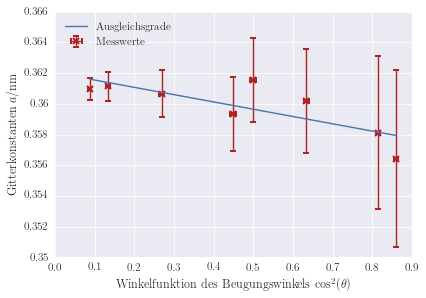

In [1273]:
# Plot der Gitterkonstante der Probe
plt.errorbar(noms(element_err.cosThetaSq.values),noms(element_err.a.values),
             xerr=stds(element_err.cosThetaSq.values),yerr=stds(element_err.a.values),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte")
plt.plot(X,linear(X,*popt_e),label="Ausgleichsgrade")
axis_scale("y",0.1)
plt.xlabel(axis_label("Winkelfunktion des Beugungswinkels",sym="\\cos^2(\\theta)"))
plt.ylabel(axis_label("Gitterkonstanten",sym="a",unit="nm"))
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Gitterkonstante_Probe.pdf")

In [1217]:
#cscl.m[:len(salt_err)][::-1]
salt_err.d_bragg

0         3.37+/-0.09
1         2.57+/-0.05
2       1.935+/-0.029
3       1.617+/-0.020
4       1.509+/-0.017
5       1.416+/-0.015
6       1.274+/-0.012
7       1.219+/-0.011
8       1.055+/-0.007
9       0.963+/-0.005
10      0.939+/-0.005
11      0.917+/-0.004
12    0.8737+/-0.0031
13    0.8529+/-0.0027
14    0.8365+/-0.0023
Name: d_bragg, dtype: object

In [1291]:
salt_err["a"] = salt_err.d_bragg * cscl.m[:len(salt_err)]
#cscl.m[:len(salt_err)]
#salt_err = salt_err.sort("cosThetaSq")

In [1279]:
salt_err[["cosThetaSq","a","d_bragg"]]

,cosThetaSq,a,d_bragg
0,0.850+/-0.005,1.993+/-0.031,1.993+/-0.031
1,0.818+/-0.005,2.56+/-0.04,1.807+/-0.025
2,0.780+/-0.006,2.84+/-0.04,1.642+/-0.021
3,0.707+/-0.006,2.850+/-0.031,1.425+/-0.015
4,0.675+/-0.007,3.024+/-0.031,1.352+/-0.014
5,0.642+/-0.007,3.156+/-0.030,1.288+/-0.012
6,0.535+/-0.007,3.197+/-0.026,1.130+/-0.009
7,0.400+/-0.007,2.986+/-0.018,0.995+/-0.006
8,0.366+/-0.007,2.905+/-0.016,0.968+/-0.005
9,0.297+/-0.006,2.907+/-0.013,0.919+/-0.004


In [1248]:
def linear(x,a,b):
    return a*x +b
X = np.linspace(min(noms(salt_err.cosThetaSq.values)),max(noms(salt_err.cosThetaSq.values)),1000)
popt_s,pcov_s = sp.optimize.curve_fit(linear,noms(salt_err.cosThetaSq.values),noms(salt_err.a.values))
param_s_err = fit_errors(popt_s,pcov_s)
print_errors(param_s_err,["a","b"])

a  0.412146566494 +/- 0.160808986381
b  3.0986667737 +/- 0.0971074343104


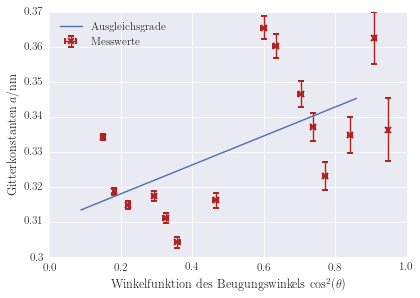

In [1292]:
# Plot der Gitterkonstante des Salzes
plt.errorbar(noms(salt_err.cosThetaSq.values),noms(salt_err.a.values),
             xerr=stds(salt_err.cosThetaSq.values),yerr=stds(salt_err.a.values),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte")
plt.plot(X,linear(X,*popt_s),label="Ausgleichsgrade")
axis_scale("y",0.1)
plt.xlabel(axis_label("Winkelfunktion des Beugungswinkels",sym="\\cos^2(\\theta)"))
plt.ylabel(axis_label("Gitterkonstanten",sym="a",unit="nm"))
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Gitterkonstante_Salz.pdf")

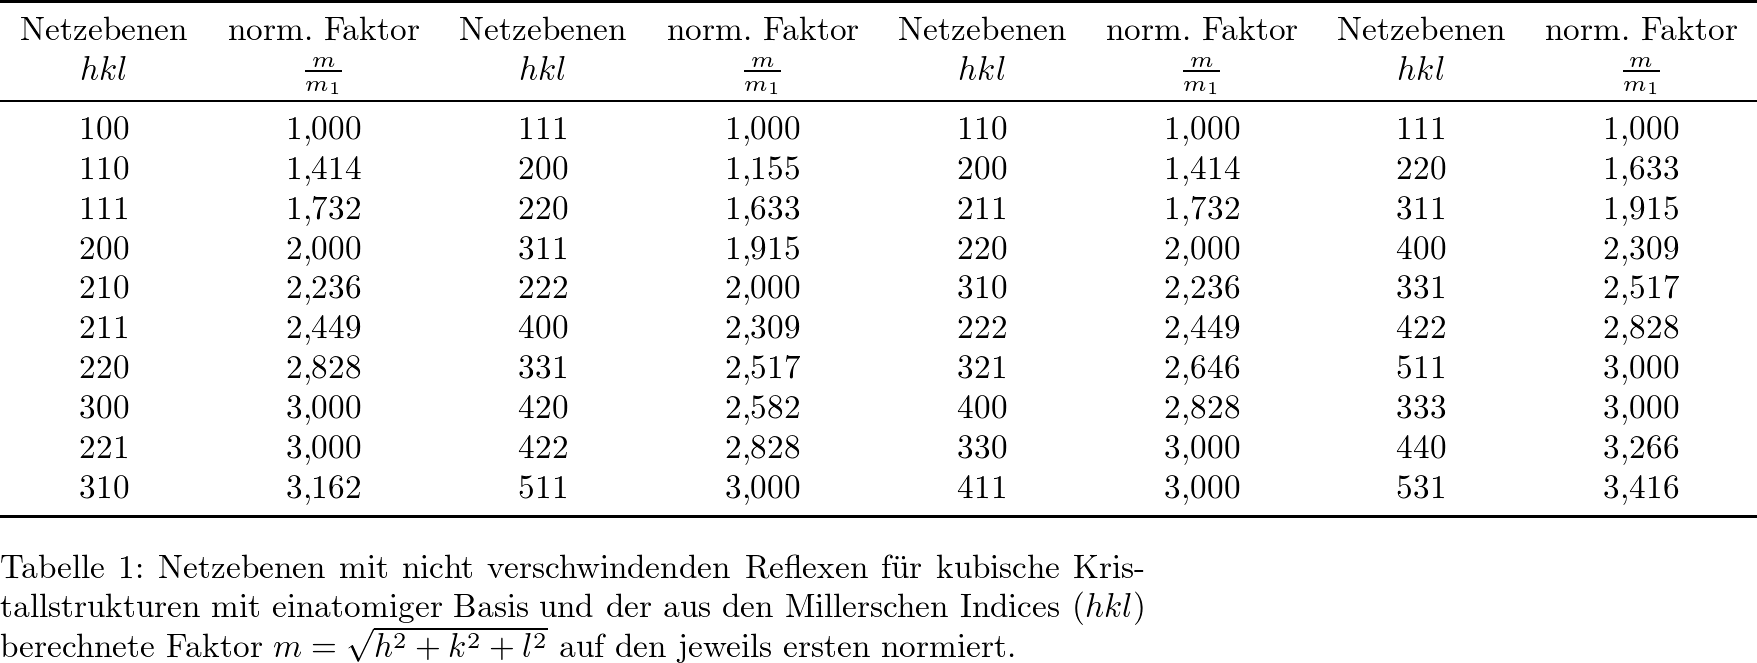

In [1250]:
Tab_refs = Table(siunitx=True,booktabs=True)
Tab_refs.caption("""Netzebenen mit nicht verschwindenden Reflexen für kubische Kristallstrukturen mit einatomiger Basis und der aus 
den Millerschen Indices ($hkl$) berechnete Faktor $m = \sqrt{h^2+k^2+l^2}$ auf den jeweils ersten normiert.""")
Tab_refs.label("reflexe_1_atom")

Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in sc.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs.addColumn(sc.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in fcc.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs.addColumn(fcc.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in bcc.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs.addColumn(bcc.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in diamond.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs.addColumn(diamond.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
#Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in nacl.hkl.values[:10]],title="Netzebenen",symbol="hkl")
#Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in flourite.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Image(Tab_refs.show(ipynb=True),width=800)
#Tab_refs.save(path_table+"Reflexe_1Atom.tex")

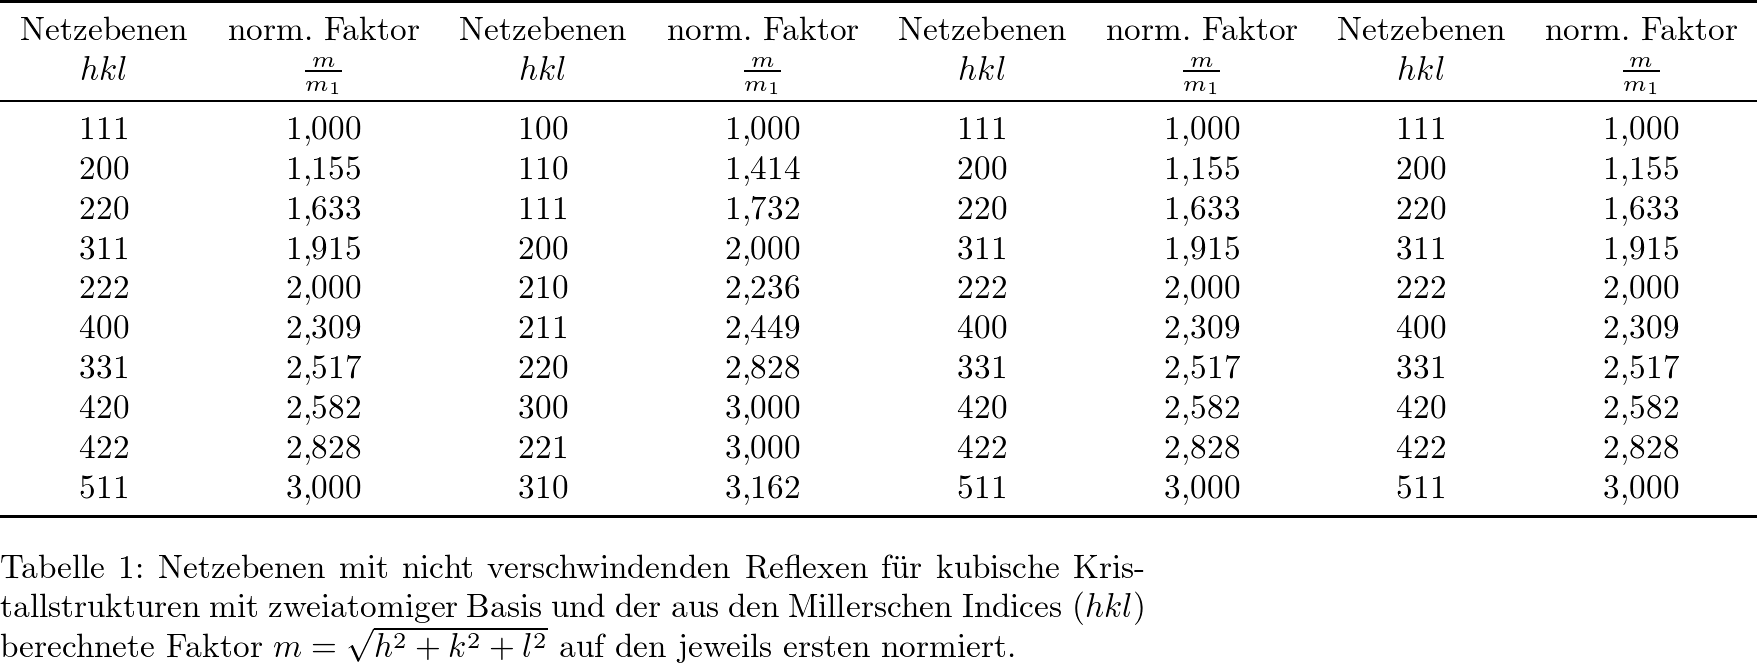

In [1130]:
Tab_refs_2 = Table(siunitx=True,booktabs=True)
Tab_refs_2.caption("""Netzebenen mit nicht verschwindenden Reflexen für kubische Kristallstrukturen mit zweiatomiger Basis und der aus 
den Millerschen Indices ($hkl$) berechnete Faktor $m = \sqrt{h^2+k^2+l^2}$ auf den jeweils ersten normiert.""")
Tab_refs_2.label("reflexe_2_atom")

Tab_refs_2.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in nacl.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs_2.addColumn(nacl.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs_2.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in cscl.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs_2.addColumn(cscl.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs_2.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in zns.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs_2.addColumn(zns.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
Tab_refs_2.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in flourite.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Tab_refs_2.addColumn(flourite.m_norm.values[:10],title="norm. Faktor",symbol="\\frac{m}{m_1}")
#Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in nacl.hkl.values[:10]],title="Netzebenen",symbol="hkl")
#Tab_refs.addColumn(["{}{}{}".format(tup[0],tup[1],tup[2]) for tup in flourite.hkl.values[:10]],title="Netzebenen",symbol="hkl")
Image(Tab_refs_2.show(ipynb=True),width=800)
#Tab_refs_2.save(path_table+"Reflexe_2Atom.tex")

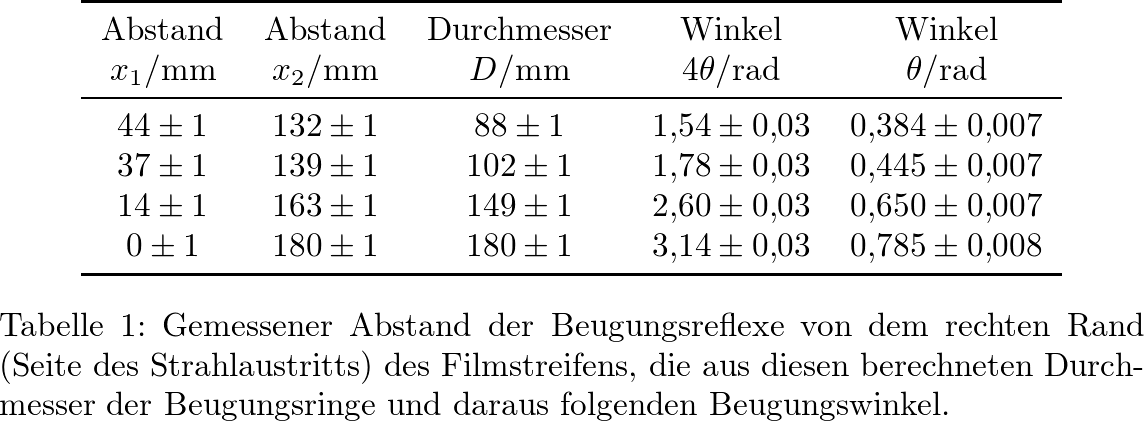

In [1251]:
#Tabellen der Messwerte:
Tab_elem_1 = Table(siunitx=True,booktabs=True)
Tab_elem_1.caption("""Gemessener Abstand der Beugungsreflexe von dem rechten Rand (Seite des Strahlaustritts) des 
                    Filmstreifens, die aus diesen berechneten Durchmesser der Beugungsringe und daraus folgenden 
                    Beugungswinkel.  
                    """)
Tab_elem_1.label("probe_rechts")
Tab_elem_1.addColumn(element_err.x1.values[:4],title="Abstand",symbol="x_1",unit="mm")
Tab_elem_1.addColumn(element_err.x2.values[:4],title="Abstand",symbol="x_2",unit="mm")
Tab_elem_1.addColumn(element_err.diameter[:4],title="Durchmesser",symbol="D",unit="mm")
Tab_elem_1.addColumn(element_err.Theta4[:4],title="Winkel",symbol="4\\theta",unit="rad")
Tab_elem_1.addColumn(element_err.Theta[:4],title="Winkel",symbol="\\theta",unit="rad")
Image(Tab_elem_1.show(ipynb=True),width=800)
#Tab_elem_1.save(path_table+"messwerte_probe_austritt.tex")

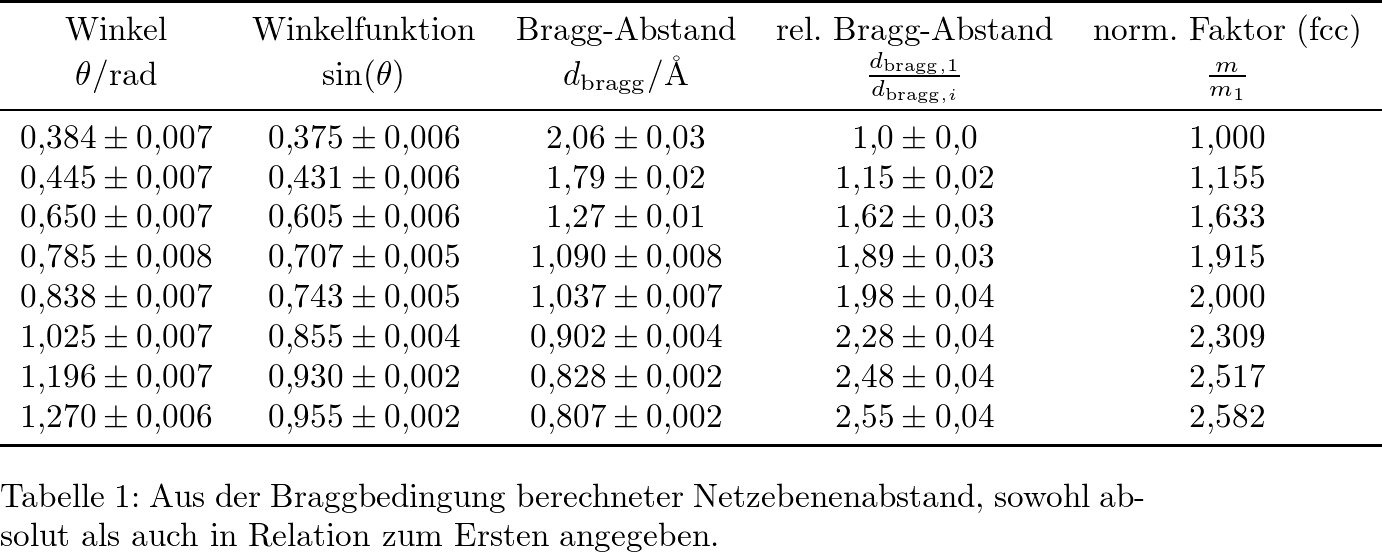

In [1254]:
#Tabellen der Messwerte:
Tab_elem_2 = Table(siunitx=True,booktabs=True)
Tab_elem_2.caption("""Aus der Braggbedingung berechneter Netzebenenabstand, 
                    sowohl absolut als auch in Relation zum Ersten angegeben. 
                    """)
Tab_elem_2.label("probe_braggabstand")
Tab_elem_2.addColumn(element_err.Theta[:],title="Winkel",symbol="\\theta",unit="rad")
Tab_elem_2.addColumn(element_err.sinTheta.values[:],title="Winkelfunktion",symbol="\\sin(\\theta)",unit=None)
Tab_elem_2.addColumn(element_err.d_bragg.values[:],title="Bragg-Abstand",symbol="d_{\\mathrm{bragg}}",unit="\\angstrom")
Tab_elem_2.addColumn(element_err.d_bragg_norm.values[:],title="rel. Bragg-Abstand",symbol="\\frac{d_{\\mathrm{bragg},1}}{d_{\\mathrm{bragg},i}}")
Tab_elem_2.addColumn(fcc.m_norm.values[:len(element_err)],title="norm. Faktor (fcc)",symbol="\\frac{m}{m_1}")
#Tab_elem_2.addColumn(element_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Image(Tab_elem_2.show(ipynb=True),width=800)
#Tab_elem_2.save(path_table+"braggabstand_probe.tex")

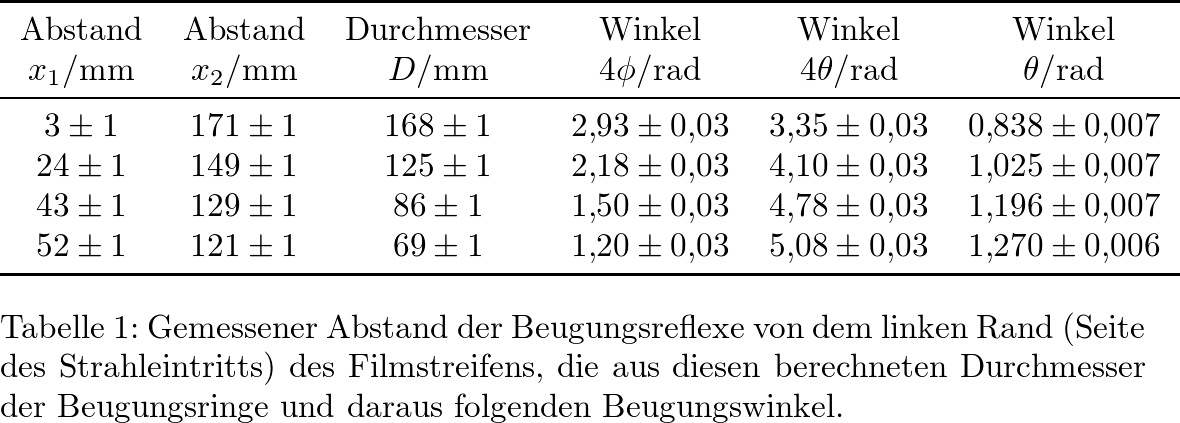

In [1162]:
#Tabellen der Messwerte:
Tab_elem_3 = Table(siunitx=True,booktabs=True)
Tab_elem_3.caption("""Gemessener Abstand der Beugungsreflexe von dem linken Rand (Seite des Strahleintritts) des 
                    Filmstreifens, die aus diesen berechneten Durchmesser der Beugungsringe und daraus folgenden 
                    Beugungswinkel.  
                    """)
Tab_elem_3.label("probe_rechts")
Tab_elem_3.addColumn(element_err.x1.values[4:],title="Abstand",symbol="x_1",unit="mm")
Tab_elem_3.addColumn(element_err.x2.values[4:],title="Abstand",symbol="x_2",unit="mm")
Tab_elem_3.addColumn(element_err.diameter[4:],title="Durchmesser",symbol="D",unit="mm")
Tab_elem_3.addColumn(element_err.Phi4[4:],title="Winkel",symbol="4\\phi",unit="rad")
Tab_elem_3.addColumn(element_err.Theta4[4:],title="Winkel",symbol="4\\theta",unit="rad")
Tab_elem_3.addColumn(element_err.Theta[4:],title="Winkel",symbol="\\theta",unit="rad")
Image(Tab_elem_3.show(ipynb=True),width=800)
#Tab_elem_3.save(path_table+"messwerte_probe_eintritt.tex")

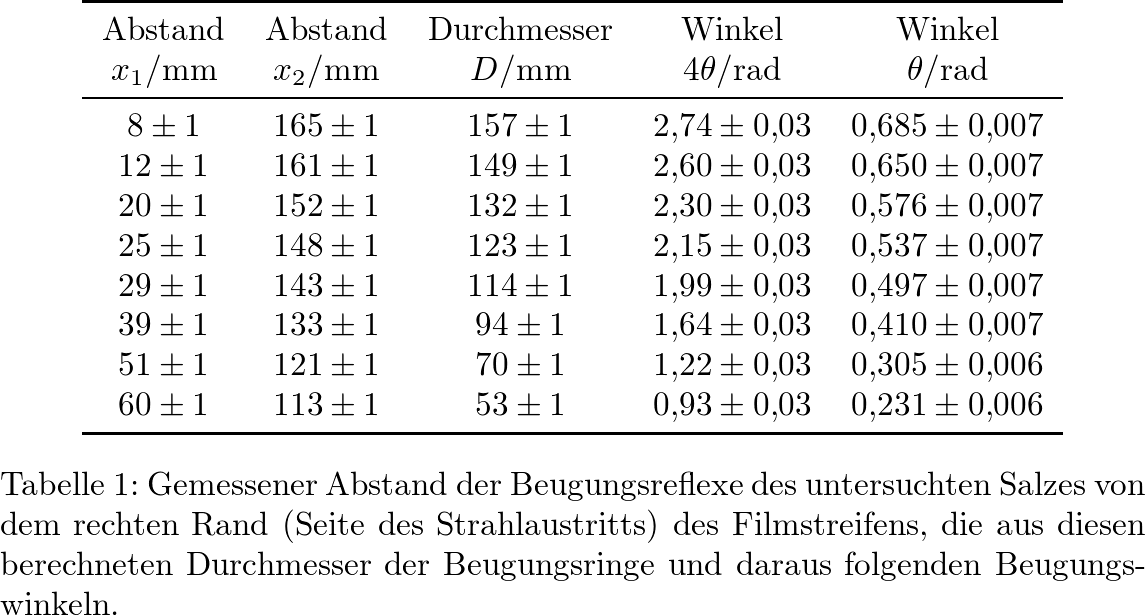

In [1161]:
#Tabellen der Messwerte:
Tab_salt_1 = Table(siunitx=True,booktabs=True)
Tab_salt_1.caption("""Gemessener Abstand der Beugungsreflexe des untersuchten Salzes von dem rechten Rand (Seite des Strahlaustritts) des 
                    Filmstreifens, die aus diesen berechneten Durchmesser der Beugungsringe und daraus folgenden 
                    Beugungswinkeln.  
                    """)
Tab_salt_1.label("probe_rechts")
Tab_salt_1.addColumn(salt_err.x1.values[7:],title="Abstand",symbol="x_1",unit="mm")
Tab_salt_1.addColumn(salt_err.x2.values[7:],title="Abstand",symbol="x_2",unit="mm")
Tab_salt_1.addColumn(salt_err.diameter[7:],title="Durchmesser",symbol="D",unit="mm")
Tab_salt_1.addColumn(salt_err.Theta4[7:],title="Winkel",symbol="4\\theta",unit="rad")
Tab_salt_1.addColumn(salt_err.Theta[7:],title="Winkel",symbol="\\theta",unit="rad")
Image(Tab_salt_1.show(ipynb=True),width=800)

#Tab_salt_1.save(path_table+"messwerte_salz_austritt.tex")

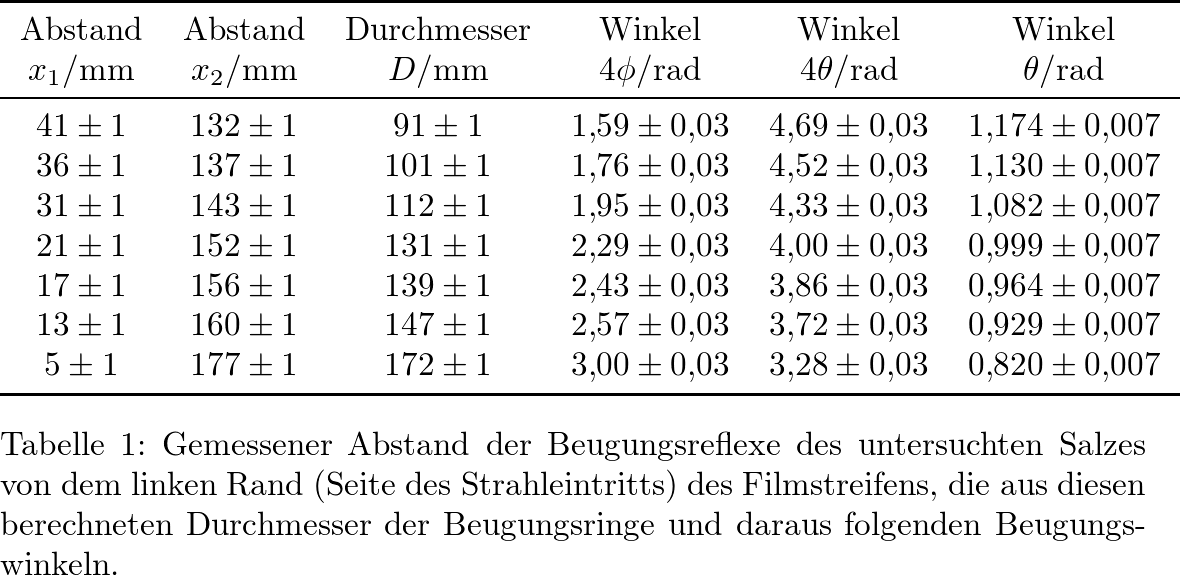

In [1165]:
#Tabellen der Messwerte:
Tab_salt_3 = Table(siunitx=True,booktabs=True)
Tab_salt_3.caption("""Gemessener Abstand der Beugungsreflexe des untersuchten Salzes von dem linken Rand (Seite des Strahleintritts) des 
                    Filmstreifens, die aus diesen berechneten Durchmesser der Beugungsringe und daraus folgenden 
                    Beugungswinkeln.  
                    """)
Tab_salt_3.label("salz_links")
Tab_salt_3.addColumn(salt_err.x1.values[:7],title="Abstand",symbol="x_1",unit="mm")
Tab_salt_3.addColumn(salt_err.x2.values[:7],title="Abstand",symbol="x_2",unit="mm")
Tab_salt_3.addColumn(salt_err.diameter[:7],title="Durchmesser",symbol="D",unit="mm")
Tab_salt_3.addColumn(salt_err.Phi4[:7],title="Winkel",symbol="4\\phi",unit="rad")
Tab_salt_3.addColumn(salt_err.Theta4[:7],title="Winkel",symbol="4\\theta",unit="rad")
Tab_salt_3.addColumn(salt_err.Theta[:7],title="Winkel",symbol="\\theta",unit="rad")
Image(Tab_salt_3.show(ipynb=True),width=800)
#Tab_salt_3.save(path_table+"messwerte_salz_eintritt.tex")

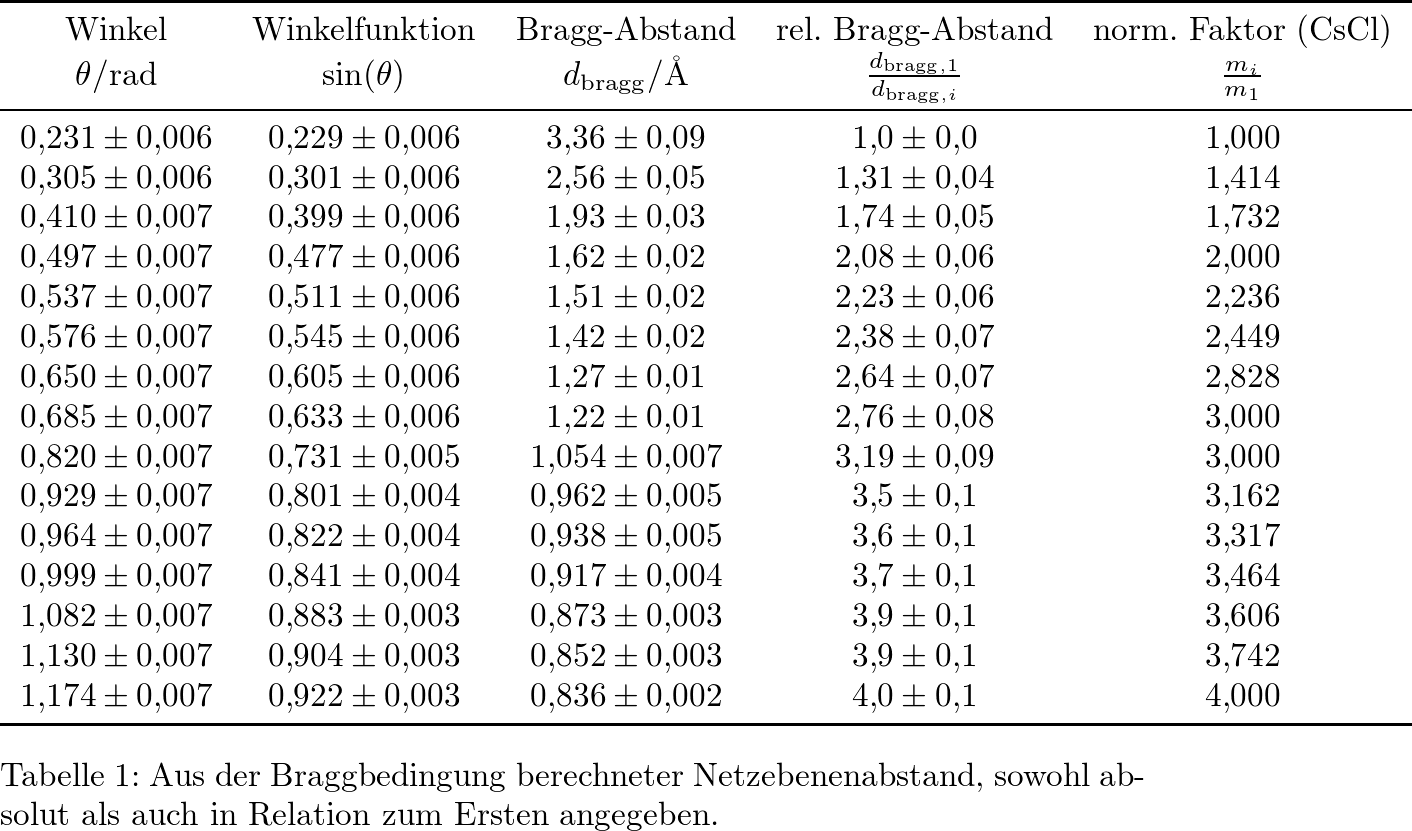

In [1257]:
Tab_salt_2 = Table(siunitx=True,booktabs=True)
Tab_salt_2.caption("""Aus der Braggbedingung berechneter Netzebenenabstand, 
                    sowohl absolut als auch in Relation zum Ersten angegeben. 
                    """)
Tab_salt_2.label("salz_braggabstand")
Tab_salt_2.addColumn(salt_err.Theta[:],title="Winkel",symbol="\\theta",unit="rad")
Tab_salt_2.addColumn(salt_err.sinTheta.values[:],title="Winkelfunktion",symbol="\\sin(\\theta)",unit=None)
Tab_salt_2.addColumn(salt_err.d_bragg.values[:],title="Bragg-Abstand",symbol="d_{\\mathrm{bragg}}",unit="\\angstrom")
Tab_salt_2.addColumn(salt_err.d_bragg_norm.values[:],title="rel. Bragg-Abstand",symbol="\\frac{d_{\\mathrm{bragg},1}}{d_{\\mathrm{bragg},i}}")
Tab_salt_2.addColumn(cscl.m_norm.values[:len(salt_err)],title="norm. Faktor (CsCl)",symbol="\\frac{m_i}{m_1}")
#Tab_elem_2.addColumn(element_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Image(Tab_salt_2.show(ipynb=True),width=800)
#Tab_salt_2.save(path_table+"braggabstand_salz.tex")

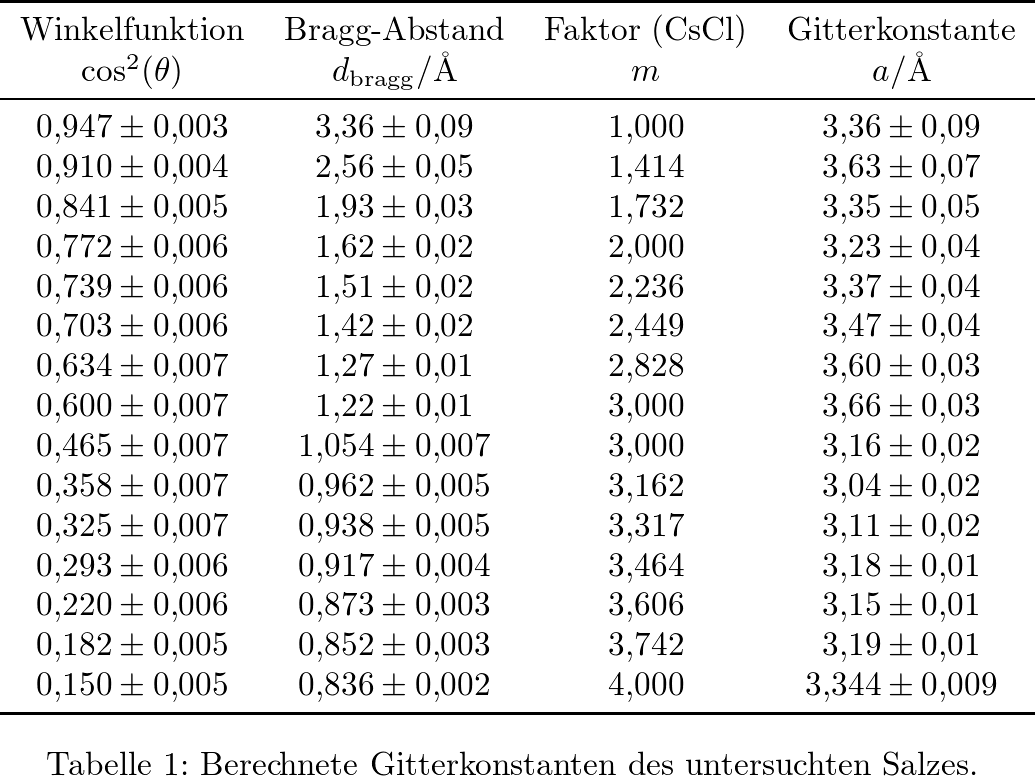

In [1262]:
Tab_salt_4 = Table(siunitx=True,booktabs=True)
Tab_salt_4.caption("""Berechnete Gitterkonstanten des untersuchten Salzes.""")
Tab_salt_4.label("salz_gitterkonstante")
Tab_salt_4.addColumn(salt_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Tab_salt_4.addColumn(salt_err.d_bragg.values[:],title="Bragg-Abstand",symbol="d_{\\mathrm{bragg}}",unit="\\angstrom")
Tab_salt_4.addColumn(cscl.m.values[:len(salt_err)],title="Faktor (CsCl)",symbol="m")
Tab_salt_4.addColumn(salt_err.a.values[:],title="Gitterkonstante",symbol="a",unit="\\angstrom")
#Tab_elem_2.addColumn(element_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Image(Tab_salt_4.show(ipynb=True),width=800)
#Tab_salt_4.save(path_table+"gitterkonstante_salz.tex")

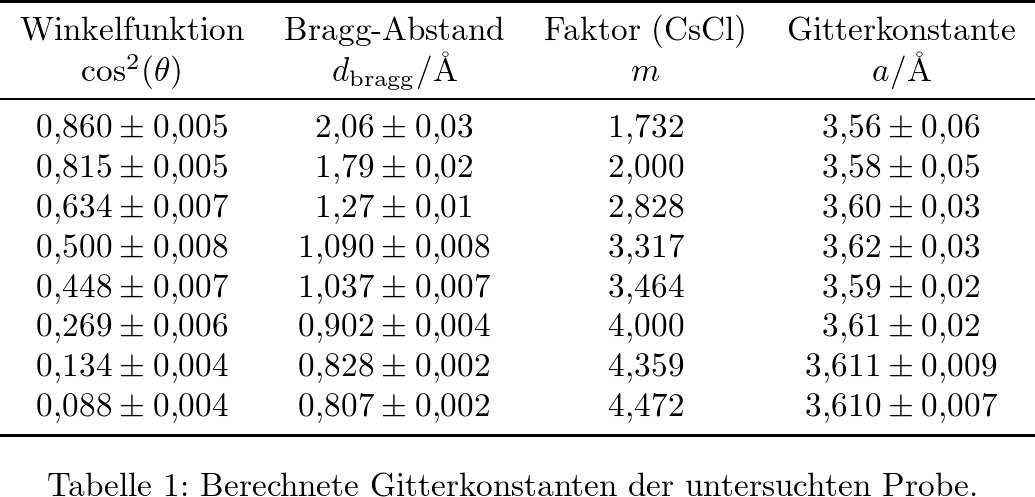

In [1269]:
Tab_element_4 = Table(siunitx=True,booktabs=True)
Tab_element_4.caption("""Berechnete Gitterkonstanten der untersuchten Probe.""")
Tab_element_4.label("probe_gitterkonstante")
Tab_element_4.addColumn(element_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Tab_element_4.addColumn(element_err.d_bragg.values[:],title="Bragg-Abstand",symbol="d_{\\mathrm{bragg}}",unit="\\angstrom")
Tab_element_4.addColumn(fcc.m.values[:len(element_err)],title="Faktor (CsCl)",symbol="m")
Tab_element_4.addColumn(element_err.a.values[:],title="Gitterkonstante",symbol="a",unit="\\angstrom")
#Tab_elem_2.addColumn(element_err.cosThetaSq.values[:],title="Winkelfunktion",symbol="\\cos^2(\\theta)",unit=None)
Image(Tab_element_4.show(ipynb=True),width=800)
#Tab_element_4.save(path_table+"gitterkonstante_probe.tex")

In [1297]:
idcs = np.arange(0,5+1)
HKL = []
for l in idcs:
    for k in idcs:
        for h in idcs:
            HKL.append((h,k,l))
HKL = HKL[1:] 
M = lambda (h,k,l): np.sqrt(h**2 + k**2 +l**2)
m_m = []
for hkl in  HKL:
    m = M(hkl)
    for hkl2 in HKL:
        m2 = M(hkl2)
        m_m.append((hkl,hkl2,m2/m))
    
    

In [1303]:
HKL
F = open("Test.txt","w")
for m in m_m:
    print(m,file=F)

np.sort(np.hstack([element_right_err.sinThetaSq,element_left_err.sinThetaSq]))

def compare_miller_indices(sinTheta,n=1,h=5,k=5,l=5):
    N = np.arange(1,n+1)
    #N = unp.uarray(N,[0]*len(N))
    H = np.arange(0,h+1)
    #H = unp.uarray(H,[0]*len(H))
    K = np.arange(0,k+1)
    #K = unp.uarray(K,[0]*len(K))
    L = np.arange(0,l+1)
    #L = unp.uarray(L,[0]*len(L))
    results =[[],[],[],[],[],[],[]]
    hkl = [[],[],[],[],[],[],[]]
    for i,sin in enumerate(sinTheta):
        for n in N:
            for l in L:
                for k in K:
                    for h in H:
                        res = ((h)**2+(k)**2+(l)**2)/sin
                        #if k+l == 0:
                            #print("h",h)
                            #print(sin)
                            #print("res",res)
                            #print("components",res.error_components())
                        results[i].append(res)
                        hkl[i].append((h,k,l))
    return np.array(results),np.array(hkl)

results,hkl = compare_miller_indices(np.sort(np.hstack([element_right_err.sinThetaSq,element_left_err.sinThetaSq])))

def findcommon(lists):
    List = lists[0]
    common_entries = []
    for l in lists[1:]:
        newList=[]
        for a in List:
            for b in l:
                if abs(b.n -a.n) < 1.7:
                    newList.append(a)
        #print(newList[0:10])
        List = newList[:]
    return np.unique(List)[1]   

def findindex(lists,value):
    indices = [] 
    for i,List in enumerate(lists):
        for j,l in enumerate(List):
            if abs(l.n -value.n) < 1.7:
                indices.append((i,j))
    return indices

  

common_result = findcommon(results)
print(common_result)
idcs = np.array(findindex(results,findcommon(results)))
constant_values=results[idcs[:,0],idcs[:,1]] 
common_result_mean = np.mean(noms(constant_values))
#for i,j in indcs:
#    possible_values.append(i,results[i,j],hkl[i,j])
#    print("angle",i,"Value",results[i,j],"hkl",hkl[i,j])

possible_values = pd.DataFrame({"index":idcs[:,0],"value":results[idcs[:,0],idcs[:,1]],"hkl":[(h,k,l) for h,k,l in hkl[idcs[:,0],idcs[:,1]]]})
possible_values["diff"] = abs(possible_values["value"] - common_result)
possible_values[possible_values["index"] ==6]

nearest_result_args = []
index_offset = 0
for i in range(5):
    distances = []
    temp = possible_values[possible_values["index"] == i]
    count = len(temp)
    nearest_result_args.append(np.argsort(abs(noms(temp.value - common_result_mean)))[:1]+index_offset)
    index_offset +=count
nearest_result_args.append(22)
nearest_result_args.append(34)
element_values = possible_values.ix[np.hstack(nearest_result_args)]
element_values

def compare_miller_indices(sinTheta,n=5,h=5,k=5,l=5):
    N = np.arange(1,n+1)
    #N = unp.uarray(N,[0]*len(N))
    H = np.arange(0,h+1)
    #H = unp.uarray(H,[0]*len(H))
    K = np.arange(0,k+1)
    #K = unp.uarray(K,[0]*len(K))
    L = np.arange(0,l+1)
    #L = unp.uarray(L,[0]*len(L))
    results =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    hkl = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i,sin in enumerate(sinTheta):
        for n in N:
            for l in L:
                for k in K:
                    for h in H:
                        res = ((h)**2+(k)**2+(l)**2)/sin
                        #if k+l == 0:
                            #print("h",h)
                            #print(sin)
                            #print("res",res)
                            #print("components",res.error_components())
                        results[i].append(res)
                        hkl[i].append((h,k,l))
    return np.array(results),np.array(hkl)

def findcommon(lists):
    List = lists[0]
    common_entries = []
    for l in lists[1:]:
        newList=[]
        for a in List:
            for b in l:
                if abs(b.n -a.n) < 4.0:
                    newList.append(a)
        #print(newList[0:10])
        List = newList[:]
    return np.unique(List) 

def findindex(lists,value):
    indices = [] 
    for i,List in enumerate(lists):
        for j,l in enumerate(List):
            if abs(l.n -value.n) < 1.7:
                indices.append((i,j))
    return indices


results,hkl = compare_miller_indices(np.sort(np.hstack([salt_right_err.sinThetaSq,salt_left_err.sinThetaSq])))

common_result = findcommon(results)
print(common_result)
#idcs = np.array(findindex(results,findcommon(results)))

#constant_values=results[idcs[:,0],idcs[:,1]] 
#common_result_mean = np.mean(noms(constant_values))

for a,b,hkl in itools.izip(results[0],results[1],hkl[1]):
    print("{:10.1f}{:10.1f} {}".format(a.n,b.n,hkl))

In [21]:
A = np.array([[[1,2,3],[1,2,3],[1,2,3]],[[4,5,6],[4,5,6],[4,5,6]],[[7,8,9],[7,8,9],[7,8,9]]])

In [22]:
A[:,:,0]

array([[1, 1, 1],
       [4, 4, 4],
       [7, 7, 7]])